In [1]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

# For image resizing
import cv2 as cv
print( f"OpenCV {cv.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Matplotlib 3.7.1

OpenCV 4.8.0

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


In [2]:
!cp drive/MyDrive/Gz/nida/dl/hw01/01_model_DenseNet201_RUN_Grad-CAM.zip ./
!unzip 01_model_DenseNet201_RUN_Grad-CAM.zip

Archive:  01_model_DenseNet201_RUN_Grad-CAM.zip
  inflating: 01_model_DenseNet201_RUN_Grad-CAM.keras  


In [3]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image

model_path = '01_model_DenseNet201_RUN_Grad-CAM.keras'  # Change this to the path of your saved model
model = tf.keras.models.load_model(model_path)
tf.keras.utils.plot_model(model, to_file='cnn1_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [ ]:
tf.keras.utils.plot_model(model, to_file='cnn1_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

1/1 [==============================] - 0s 334ms/step


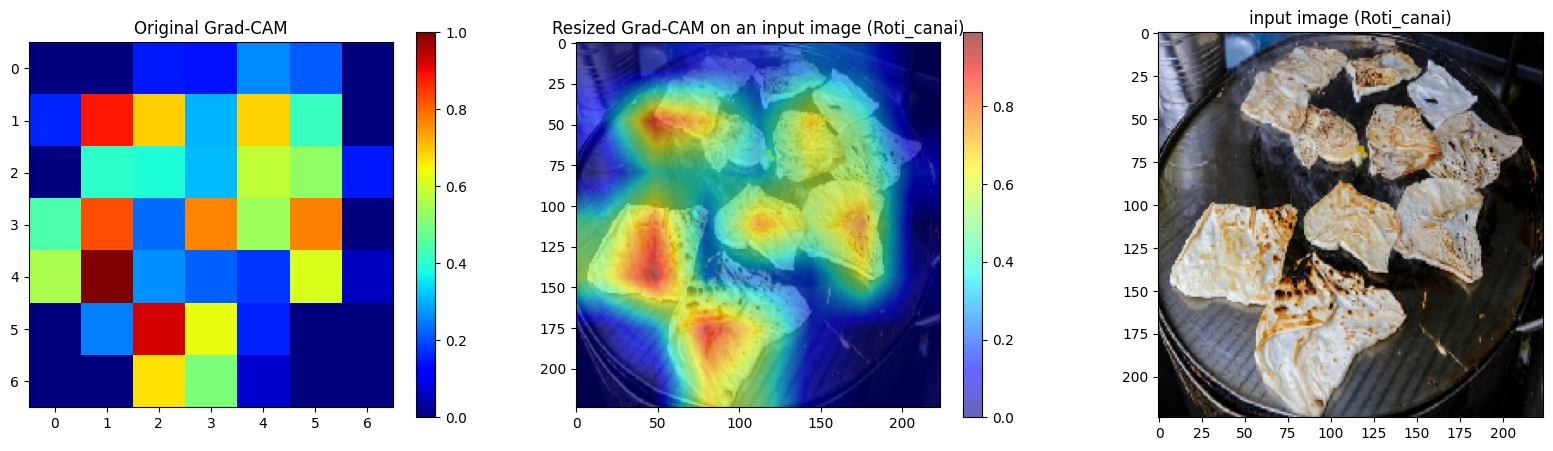

1/1 [==============================] - 0s 289ms/step


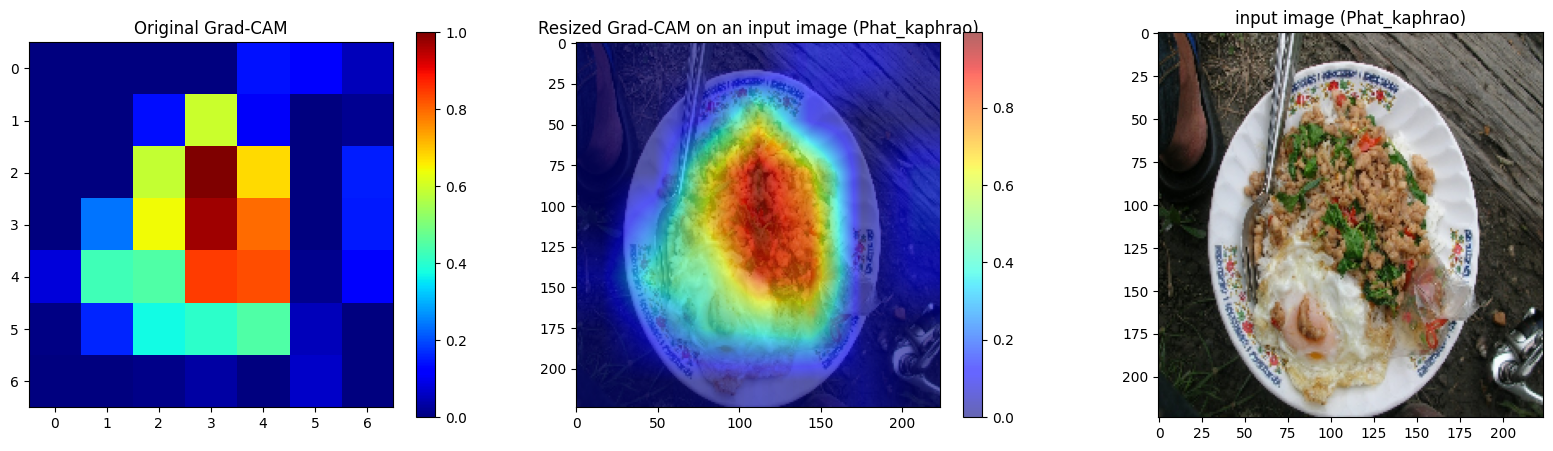

1/1 [==============================] - 0s 302ms/step


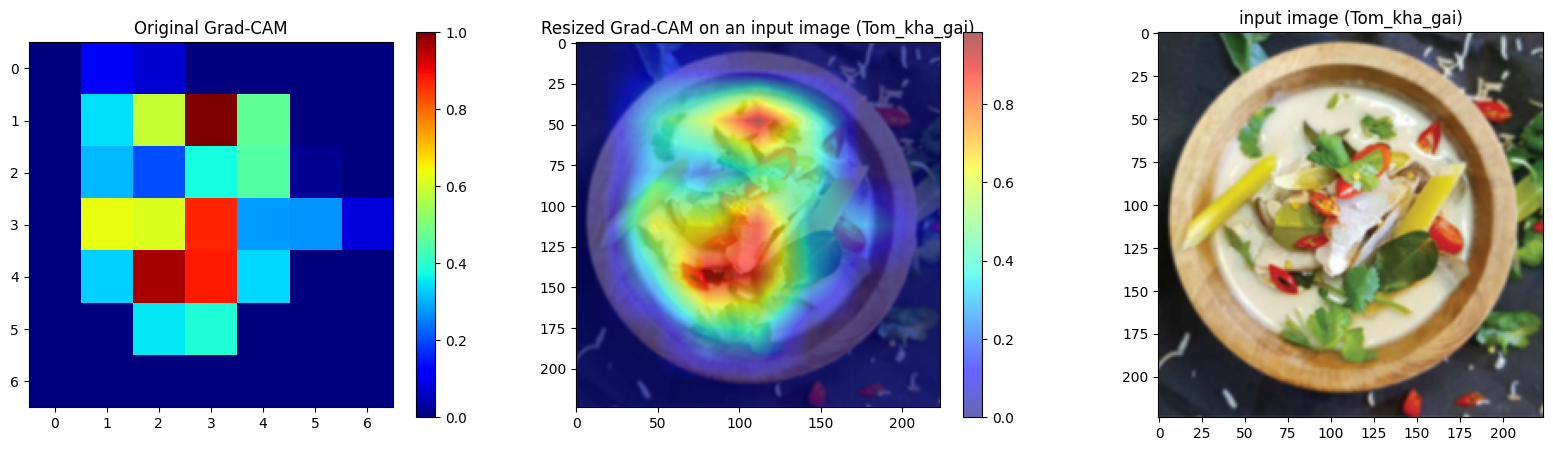

1/1 [==============================] - 0s 325ms/step


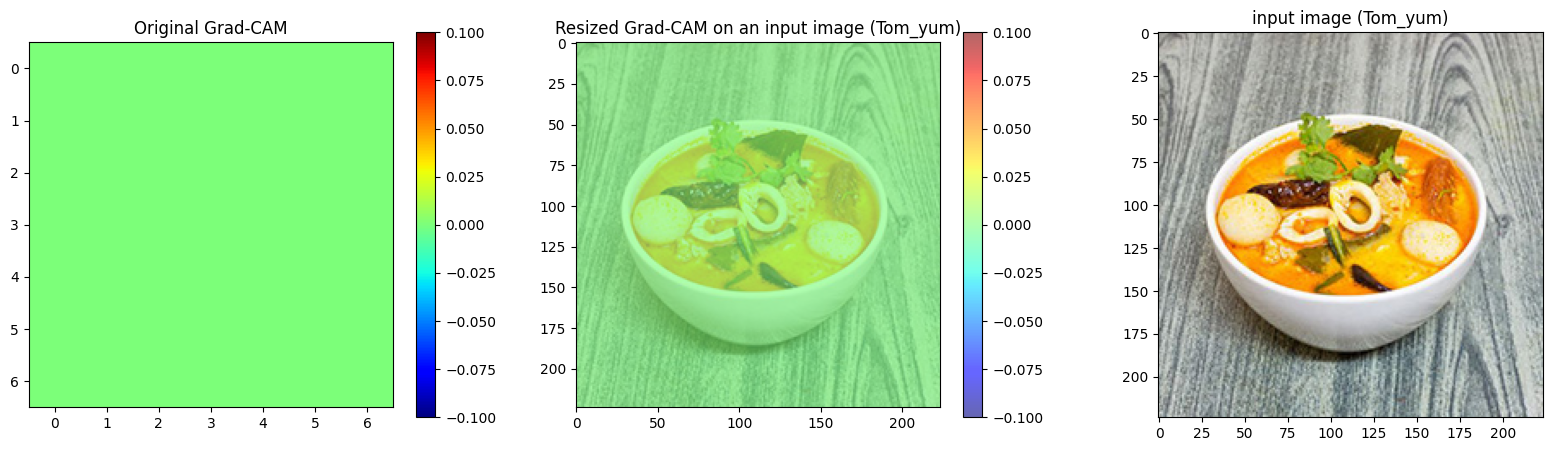

1/1 [==============================] - 0s 304ms/step


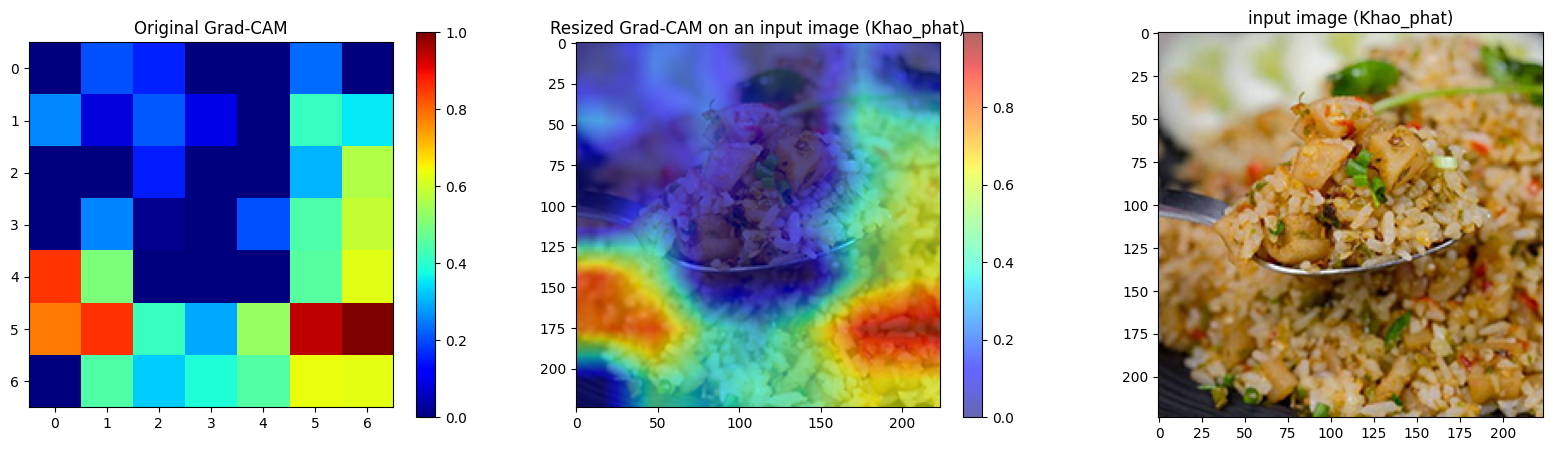

1/1 [==============================] - 0s 263ms/step


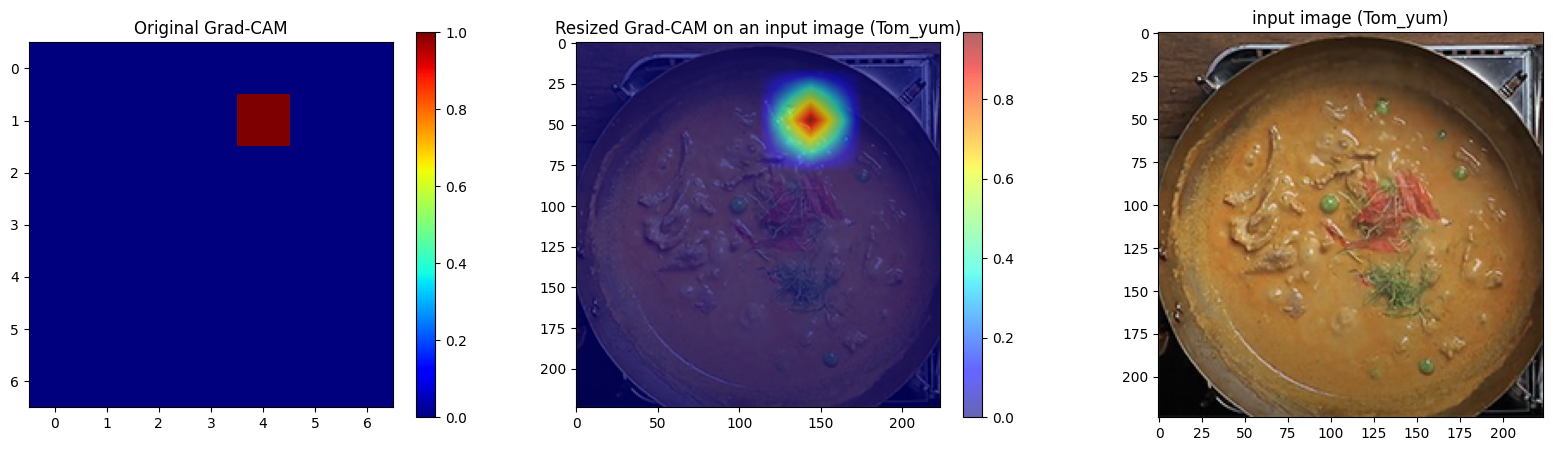

1/1 [==============================] - 0s 301ms/step


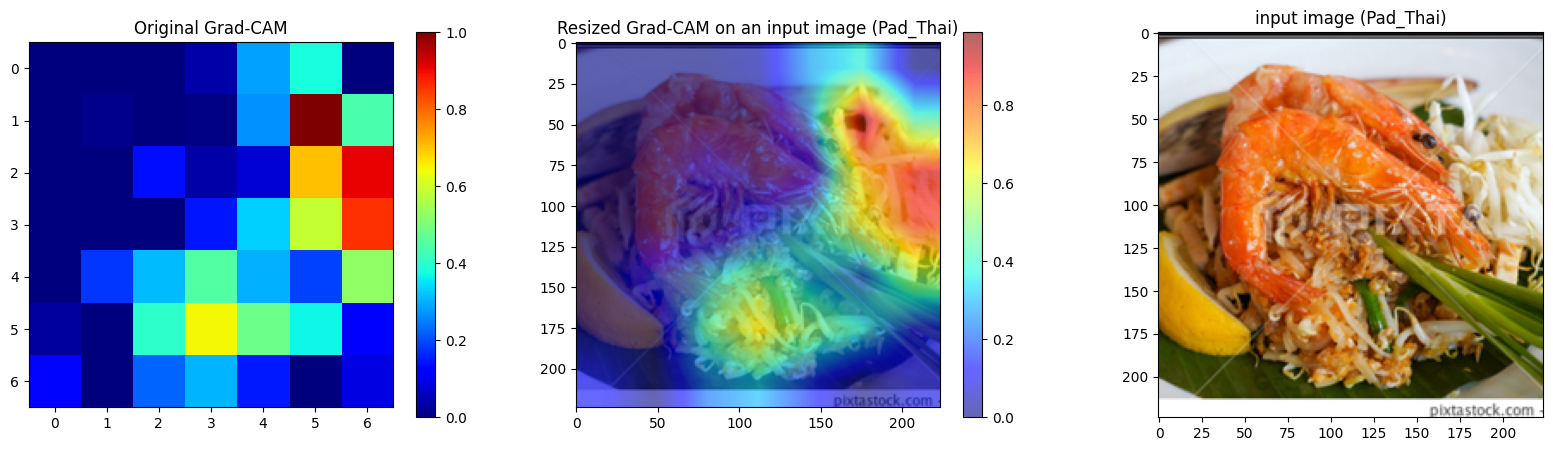

1/1 [==============================] - 0s 418ms/step


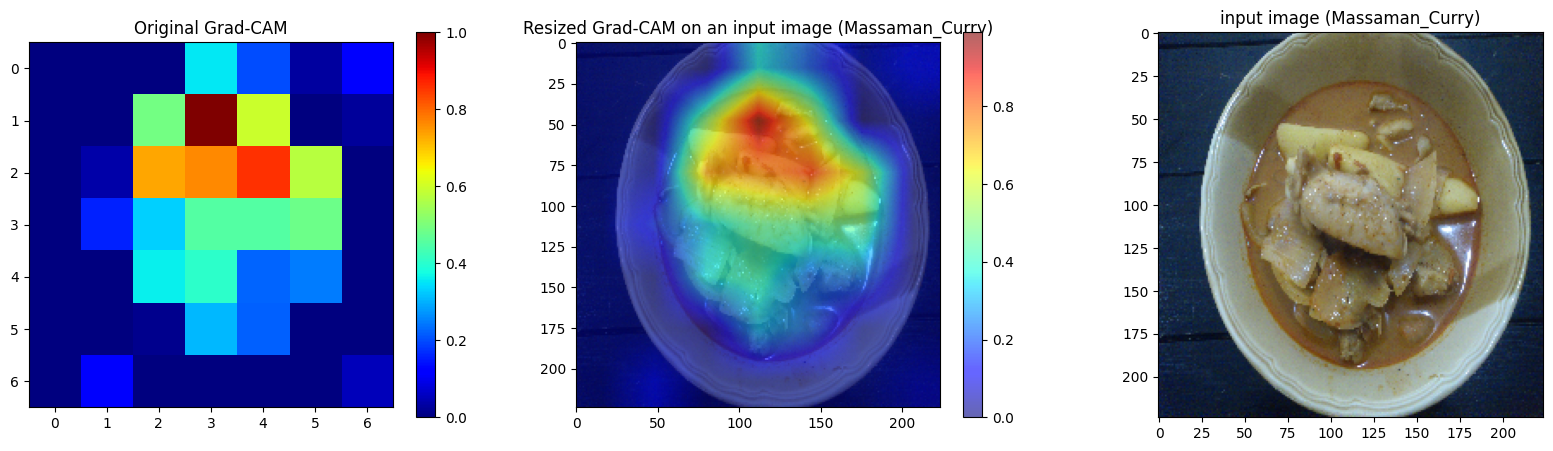

1/1 [==============================] - 0s 334ms/step


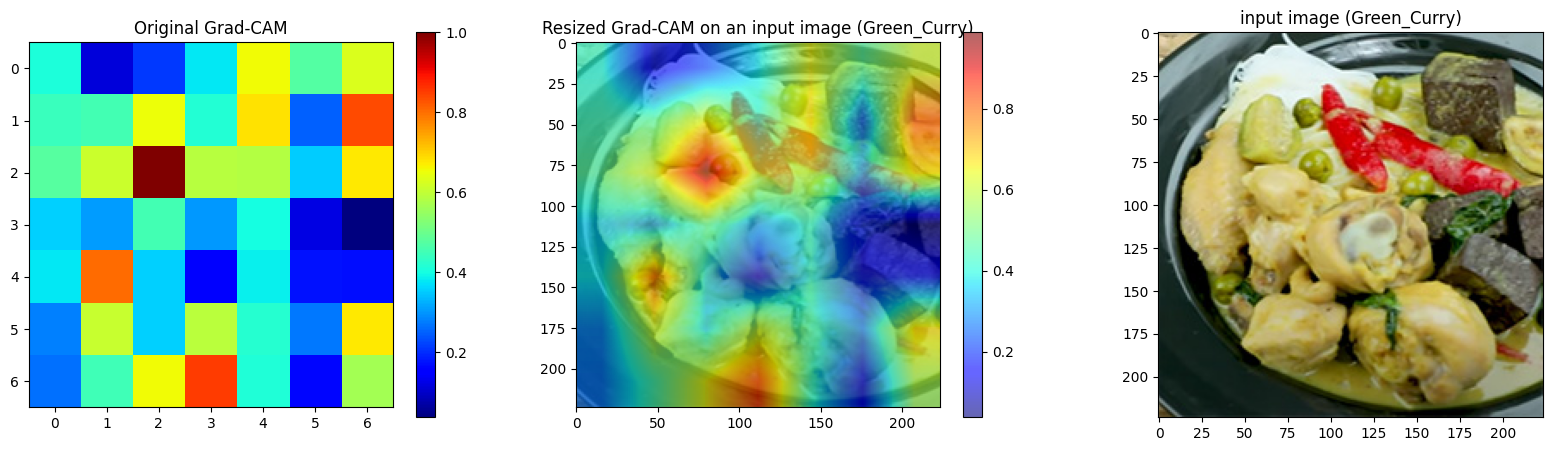

1/1 [==============================] - 0s 316ms/step


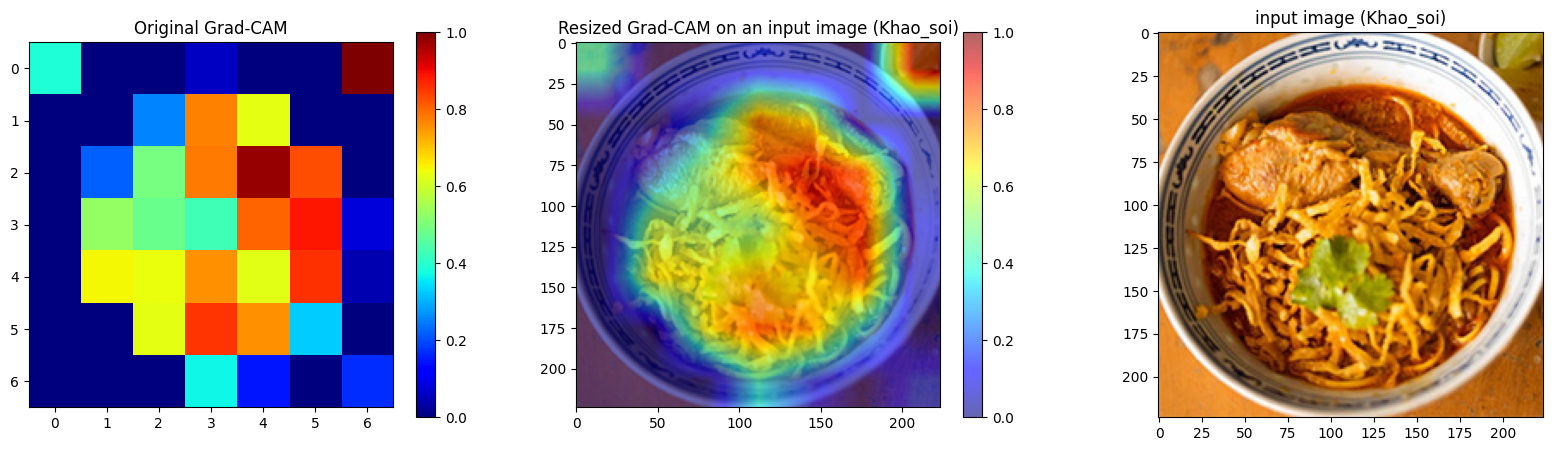

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


img_path="025.jpg"
img1 =  tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# Prepare image
def show_gradcam(img_path):

  labels = ['Green_Curry','Khao_phat','Khao_soi','Massaman_Curry','Pad_Thai','Phanaeng_Curry','Phat_kaphrao','Roti_canai','Tom_kha_gai','Tom_yum']
  thai_labels = ['แกงกะหรี่','ข้าวผัด','ข้าวซอย','มัสมั่น','ผัดไทย','พะแนง','ผักกระเพรา','โรตี','ต้มข่าไก่','ต้มยำ']

  img = image.load_img(img_path, target_size=(224, 224))
  img_array = preprocess_input(image.img_to_array(img))
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

  # Predictions for the image
  preds = model.predict(img_array)

  # We take the top predicted class index
  top_pred_index = preds.argmax(axis=1)[0]
  label = labels[top_pred_index]

  # Last conv layer name
  last_conv_layer_name = 'conv5_block16_concat'  # Name of the last convolutional layer in DenseNet201

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=top_pred_index)

  fig = plt.figure(figsize=(20,5))
  ax = fig.add_subplot(1, 3, 1)
  ax.set_title( "Original Grad-CAM" )
  im = ax.imshow( heatmap, cmap='jet' )
  plt.colorbar( im, ax=ax )

  ax = fig.add_subplot(1, 3, 2)
  title=f"Resized Grad-CAM on an input image ({label})"
  ax.set_title( title )
  ax.imshow( img )
  alpha = 0.6
  img_array = keras_image.img_to_array(img)
  #im = ax.imshow( cv.resize( heatmap, img.shape[:2] ), cmap='jet', alpha=alpha )
  im = ax.imshow( cv.resize( heatmap, img_array.shape[:2] ), cmap='jet', alpha=alpha )
  plt.colorbar( im, ax=ax )

  ax = fig.add_subplot(1, 3, 3)
  title=f"input image ({label})"
  ax.set_title( title )
  ax.imshow( img )

  # Show this figure
  plt.show()

show_gradcam("025.jpg")
show_gradcam("068.jpg")
show_gradcam("091.jpg")
show_gradcam("094.jpg")
show_gradcam("137.jpg")
show_gradcam("151.jpg")
show_gradcam("187.jpg")
show_gradcam("190.jpg")
show_gradcam("222.jpg")
show_gradcam("236.jpg")

1/1 [==============================] - 0s 426ms/step


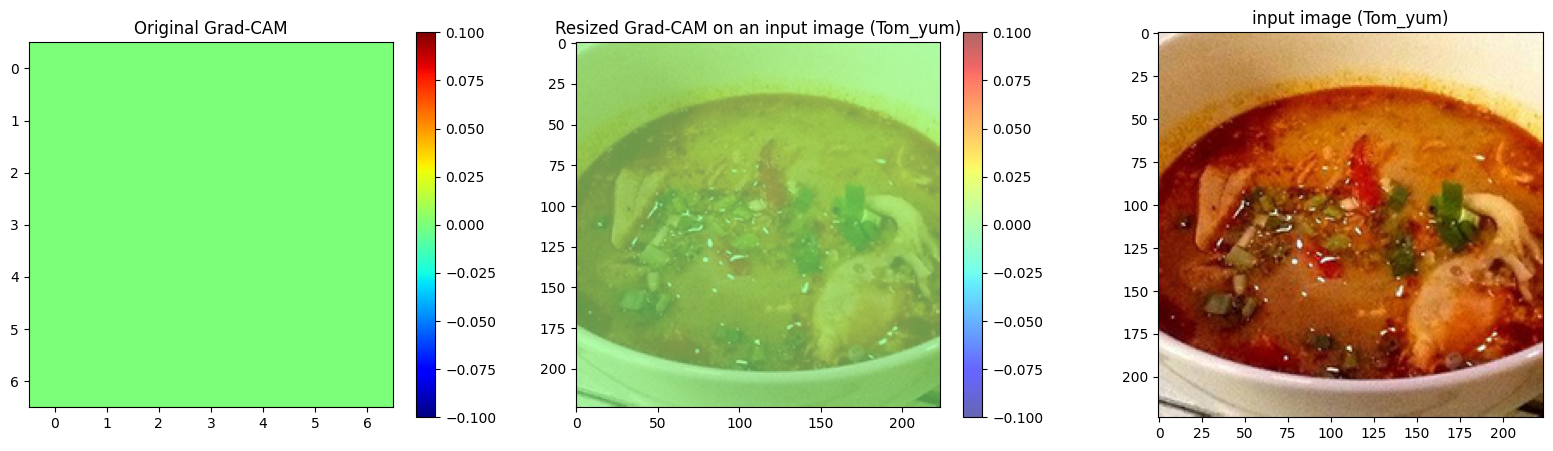

1/1 [==============================] - 0s 297ms/step


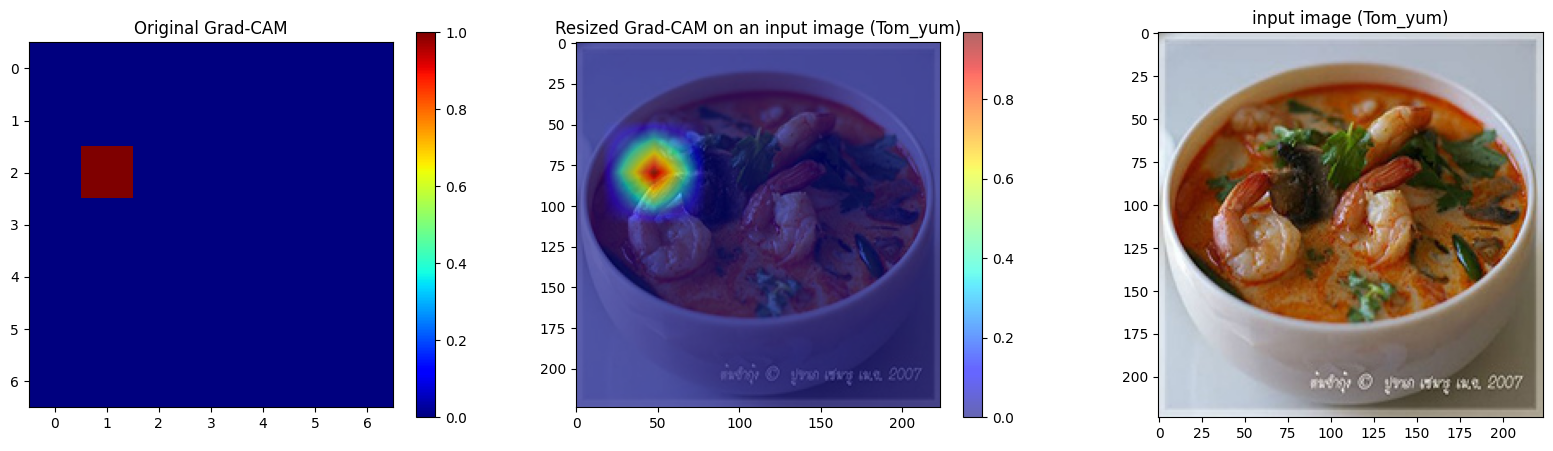

1/1 [==============================] - 0s 276ms/step


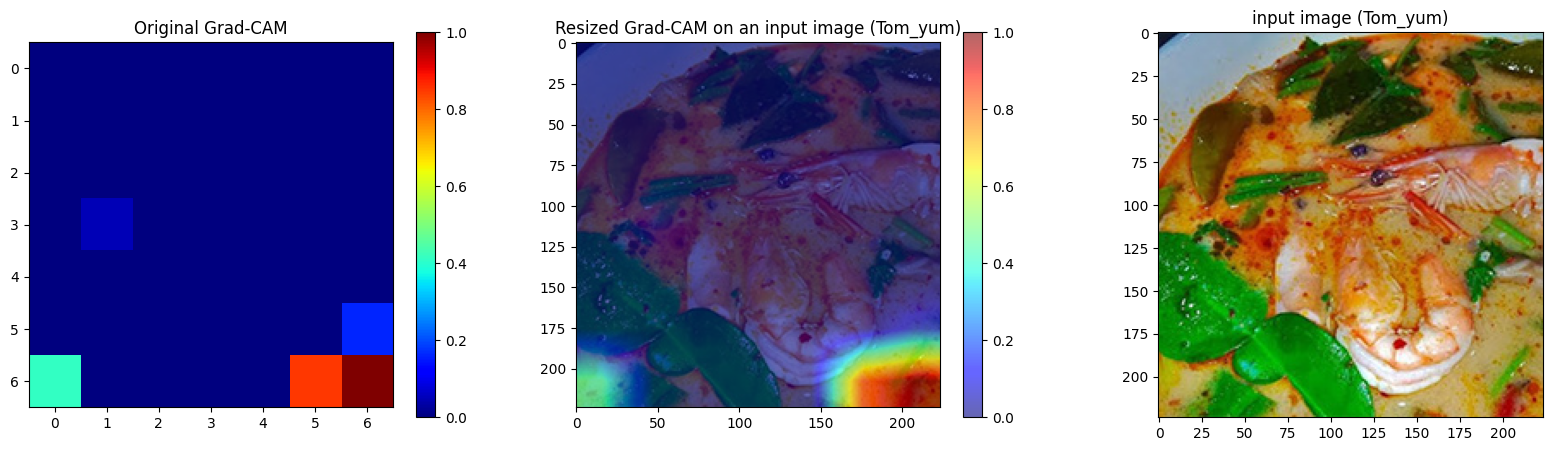

In [24]:
show_gradcam("214.jpg")
show_gradcam("219.jpg")
show_gradcam("238.jpg")

1/1 [==============================] - 0s 222ms/step


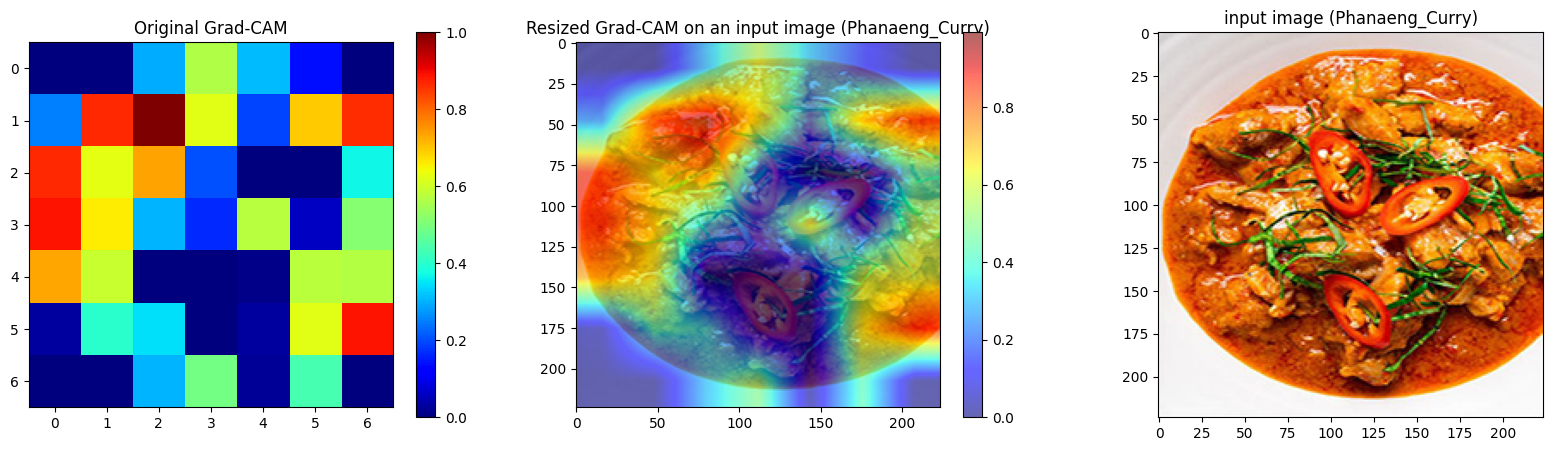

In [25]:
show_gradcam("012.jpg")